In [2]:
import sddk
import pandas as pd
import tabulate
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import geopandas as gpd
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import tempun

import pickle

import nltk
from nltk.util import bigrams
import matplotlib.colors as mcolors

In [3]:
EDHCSg = sddk.read_file("EDHCSg.geojson", "gdf", "a9237c5ea642d4714bcdefb03f70a1f4")

reading file located in a public folder


In [4]:
len(EDHCSg)

137305

In [5]:
EDH_overlap_all = EDHCSg[(EDHCSg["EDH-ID"].notnull()) & (EDHCSg["EDCS-ID"].notnull())] 
len(EDH_overlap_all)

49916

In [6]:
len(EDHCSg[(EDHCSg["EDH-ID"].notnull()) & (EDHCSg["EDCS-ID"].isnull())])

3907

In [7]:
len(EDHCSg[(EDHCSg["EDH-ID"].isnull()) & (EDHCSg["EDCS-ID"].notnull())])

83482

In [70]:
class_overview_df = pd.DataFrame([
    dict(EDHCSg[EDHCSg["EDH-ID"].notnull()].groupby("type_of_inscription_auto").size().sort_values(ascending=False)),
    dict(EDHCSg[EDHCSg["EDH-ID"].isnull()].groupby("type_of_inscription_auto").size().sort_values(ascending=False))]).T
class_overview_df.fillna(0, inplace=True)
class_overview_df.columns = ["EDH", "EDCS"]
class_overview_df

,EDH,EDCS
epitaph,22902.0,62357.0
votive inscription,12328.0,4010.0
owner/artist inscription,3851.0,6826.0
honorific inscription,3089.0,2255.0
building/dedicatory inscription,2699.0,935.0
mile-/leaguestone,1413.0,1385.0
identification inscription,1182.0,23.0
acclamation,364.0,4.0
defixio,273.0,25.0
list,265.0,73.0


In [81]:
# to save figures
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [83]:
figpath = "SDAM_data/EDHCS/CHR2021/"

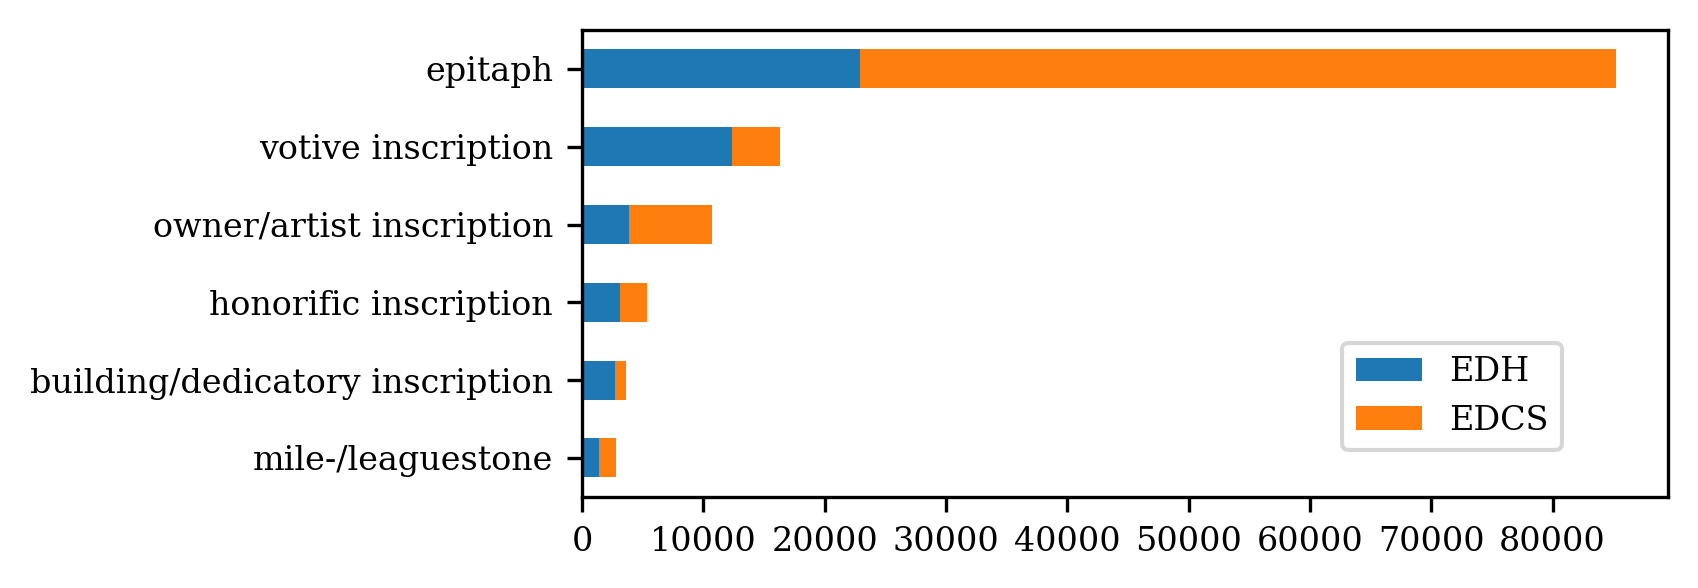

In [87]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 2), dpi=300, tight_layout=True)
class_overview_df[:6][::-1].plot.barh(stacked=True, ax=ax)
ax.legend(loc=[0.7,0.1])

In [88]:
s.write_file(figpath + "static_overview.png", fig)

A file with the same name ("static_overview.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/EDHCS/CHR2021/static_overview.png"


In [50]:
columns = ["inscr. type", "EDH", "EDCS"]

In [92]:
class_overview_df.reset_index(inplace=True)
columns = ["inscr. type", "EDH", "EDCS"]
class_overview_df.columns = columns
class_overview_df["EDH"] = class_overview_df["EDH"].astype(int)
class_overview_df["EDCS"] = class_overview_df["EDCS"].astype(int)
class_overview_df

,inscr. type,EDH,EDCS
0,epitaph,22902,62357
1,votive inscription,12328,4010
2,owner/artist inscription,3851,6826
3,honorific inscription,3089,2255
4,building/dedicatory inscription,2699,935
5,mile-/leaguestone,1413,1385
6,identification inscription,1182,23
7,acclamation,364,4
8,defixio,273,25
9,list,265,73


In [97]:
inscr_types_unique = class_overview_df["inscr. type"].tolist()
inscr_types_unique

['epitaph',
 'votive inscription',
 'owner/artist inscription',
 'honorific inscription',
 'building/dedicatory inscription',
 'mile-/leaguestone',
 'identification inscription',
 'acclamation',
 'defixio',
 'list',
 'military diploma',
 'label',
 'boundary inscription',
 'elogium',
 'letter',
 'public legal inscription',
 'seat inscription',
 'private legal inscription',
 'prayer',
 'assignation inscription',
 'calendar',
 'adnuntiatio']

In [42]:
class_overview_df[:11].append(class_overview_df[11:])

,inscr. type,EDH,EDCS
0,epitaph,22902,62357
1,votive inscription,12328,4010
2,owner/artist inscription,3851,6826
3,honorific inscription,3089,2255
4,building/dedicatory inscription,2699,935
5,mile-/leaguestone,1413,1385
6,identification inscription,1182,23
7,acclamation,364,4
8,defixio,273,25
9,list,265,73


In [46]:
class_overview_df[11:].reset_index().drop("index", axis=1)

,inscr. type,EDH,EDCS
0,label,213,7
1,boundary inscription,181,218
2,elogium,135,6
3,letter,124,6
4,public legal inscription,119,18
5,seat inscription,46,0
6,private legal inscription,38,1
7,prayer,20,0
8,assignation inscription,16,5
9,calendar,11,0


In [48]:
class_overview_df_2col = pd.concat([class_overview_df[:11], class_overview_df[11:].reset_index().drop("index", axis=1)], axis=1, ignore_index=True)
class_overview_df_2col

,0,1,2,3,4,5
0,epitaph,22902,62357,label,213,7
1,votive inscription,12328,4010,boundary inscription,181,218
2,owner/artist inscription,3851,6826,elogium,135,6
3,honorific inscription,3089,2255,letter,124,6
4,building/dedicatory inscription,2699,935,public legal inscription,119,18
5,mile-/leaguestone,1413,1385,seat inscription,46,0
6,identification inscription,1182,23,private legal inscription,38,1
7,acclamation,364,4,prayer,20,0
8,defixio,273,25,assignation inscription,16,5
9,list,265,73,calendar,11,0


In [51]:
class_overview_df_2col.columns = columns + columns
class_overview_df_2col

,inscr. type,EDH,EDCS,inscr. type,EDH,EDCS
0,epitaph,22902,62357,label,213,7
1,votive inscription,12328,4010,boundary inscription,181,218
2,owner/artist inscription,3851,6826,elogium,135,6
3,honorific inscription,3089,2255,letter,124,6
4,building/dedicatory inscription,2699,935,public legal inscription,119,18
5,mile-/leaguestone,1413,1385,seat inscription,46,0
6,identification inscription,1182,23,private legal inscription,38,1
7,acclamation,364,4,prayer,20,0
8,defixio,273,25,assignation inscription,16,5
9,list,265,73,calendar,11,0


In [53]:
print(class_overview_df_2col.to_latex(index=False))

\begin{tabular}{lrrlrr}
\toprule
                     inscr. type &    EDH &   EDCS &                inscr. type &  EDH &  EDCS \\
\midrule
                         epitaph &  22902 &  62357 &                      label &  213 &     7 \\
              votive inscription &  12328 &   4010 &       boundary inscription &  181 &   218 \\
        owner/artist inscription &   3851 &   6826 &                    elogium &  135 &     6 \\
           honorific inscription &   3089 &   2255 &                     letter &  124 &     6 \\
 building/dedicatory inscription &   2699 &    935 &   public legal inscription &  119 &    18 \\
               mile-/leaguestone &   1413 &   1385 &           seat inscription &   46 &     0 \\
      identification inscription &   1182 &     23 &  private legal inscription &   38 &     1 \\
                     acclamation &    364 &      4 &                     prayer &   20 &     0 \\
                         defixio &    273 &     25 &    assignation inscript

In [90]:
%%time
# Generate a list of 1000 random dates for each inscription in the dataset
EDHCSg["random_dates"] = EDHCSg.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 1min 17s, sys: 1.56 s, total: 1min 19s
Wall time: 1min 19s


In [181]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_inscr_type(el):
    if isinstance(el, str):
        try: el = eval(el)
        except: el = [el]
        if el != None:
            return el
        else:
            return []
    elif isinstance(el, dict):
        return []
    else:
        return []
EDHCSg["inscr_type_clean"] = EDHCSg["inscr_type"].apply(clean_inscr_type)

In [185]:
inscr_type_list_flat = [el for ellist in EDHCSg["inscr_type_clean"].tolist() for el in ellist]
inscr_types_edcs_freqs = list(nltk.FreqDist(inscr_type_list_flat).most_common())
inscr_types_edcs = [tup[0] for tup in inscr_types_edcs_freqs]
inscr_types_edcs[:10]

['tituli sepulcrales',
 'tituli sacri',
 'inscriptiones christianae',
 'tituli fabricationis',
 'tituli operum',
 'tituli possessionis',
 'tituli honorarii',
 'miliaria',
 'carmina',
 'termini']

In [183]:
inscr_types_edcs_freqs

[('tituli sepulcrales', 66983),
 ('tituli sacri', 17607),
 ('inscriptiones christianae', 15742),
 ('tituli fabricationis', 9023),
 ('tituli operum', 6341),
 ('tituli possessionis', 4346),
 ('tituli honorarii', 4084),
 ('miliaria', 2593),
 ('carmina', 1300),
 ('termini', 402),
 ('diplomata militaria', 340),
 ('leges', 339),
 ('defixiones', 296),
 ('signacula', 250),
 ('reges', 37),
 ('senatus consulta', 14)]

In [194]:
subset_df = EDHCSg[(EDHCSg["EDCS-ID"].notnull()) & (EDHCSg["inscr_type_clean"]== "tituli sepulcrales")]
len(subset_df)

0

In [195]:
%%time
# Inscriptions by their type over time, EDH

simulations_by_type_EDH = []

for ins_type in inscr_types_unique[:10]:
    subset_df = EDHCSg[(EDHCSg["EDH-ID"].notnull()) & (EDHCSg["type_of_inscription_auto"]== ins_type)]
    simulations = tempun.timeblocks_from_randoms(subset_df, "random_dates", [-50, 350, 50])
    ins_type_N = len(subset_df)
    simulations_by_type_EDH.append([ins_type, ins_type_N, simulations])
simulations_by_type_EDH = sorted(simulations_by_type_EDH, key=lambda x: x[1], reverse=True)

simulations_by_type_EDCS = []

for ins_type in inscr_types_edcs[:10]:
    subset_df = EDHCSg[(EDHCSg["EDCS-ID"].notnull()) & (EDHCSg["inscr_type_clean"].apply(lambda x: ins_type in x))]
    simulations = tempun.timeblocks_from_randoms(subset_df, "random_dates", [-50, 350, 50])
    ins_type_N = len(subset_df)
    simulations_by_type_EDCS.append([ins_type, ins_type_N, simulations])
simulations_by_type_EDCS = sorted(simulations_by_type_EDCS, key=lambda x: x[1], reverse=True)


# Inscriptions by their type over time, EDCS

simulations_by_type_EDHCS = []

for ins_type in inscr_types_unique[:10]:
    subset_df = EDHCSg[EDHCSg["type_of_inscription_auto"]== ins_type]
    simulations = tempun.timeblocks_from_randoms(subset_df, "random_dates", [-50, 350, 50])
    ins_type_N = len(subset_df)
    simulations_by_type_EDHCS.append([ins_type, ins_type_N, simulations])
simulations_by_type_EDHCS = sorted(simulations_by_type_EDHCS, key=lambda x: x[1], reverse=True)

CPU times: user 14.1 s, sys: 79.2 ms, total: 14.2 s
Wall time: 14.2 s


In [212]:
tab_colors_list

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [211]:
base_colors_10 = list(mcolors.BASE_COLORS.keys())[:6] + ["sienna", "turquoise", "chartreuse", "blueviolet"]
base_colors_10

['b',
 'g',
 'r',
 'c',
 'm',
 'y',
 'sienna',
 'turquoise',
 'chartreuse',
 'blueviolet']

In [204]:
tab_colors_list_edcs = ['tab:blue', 
                        'goldenrod', 
                        'tab:orange', 
                        'teal',
                        'maroon',
                        'tab:green',
                        'tab:red',
                        'tab:brown',
                        'lightcoral',
                        'tab:olive']

CPU times: user 740 ms, sys: 47.8 ms, total: 788 ms
Wall time: 784 ms


Text(0.5, 1.0, '(c)')

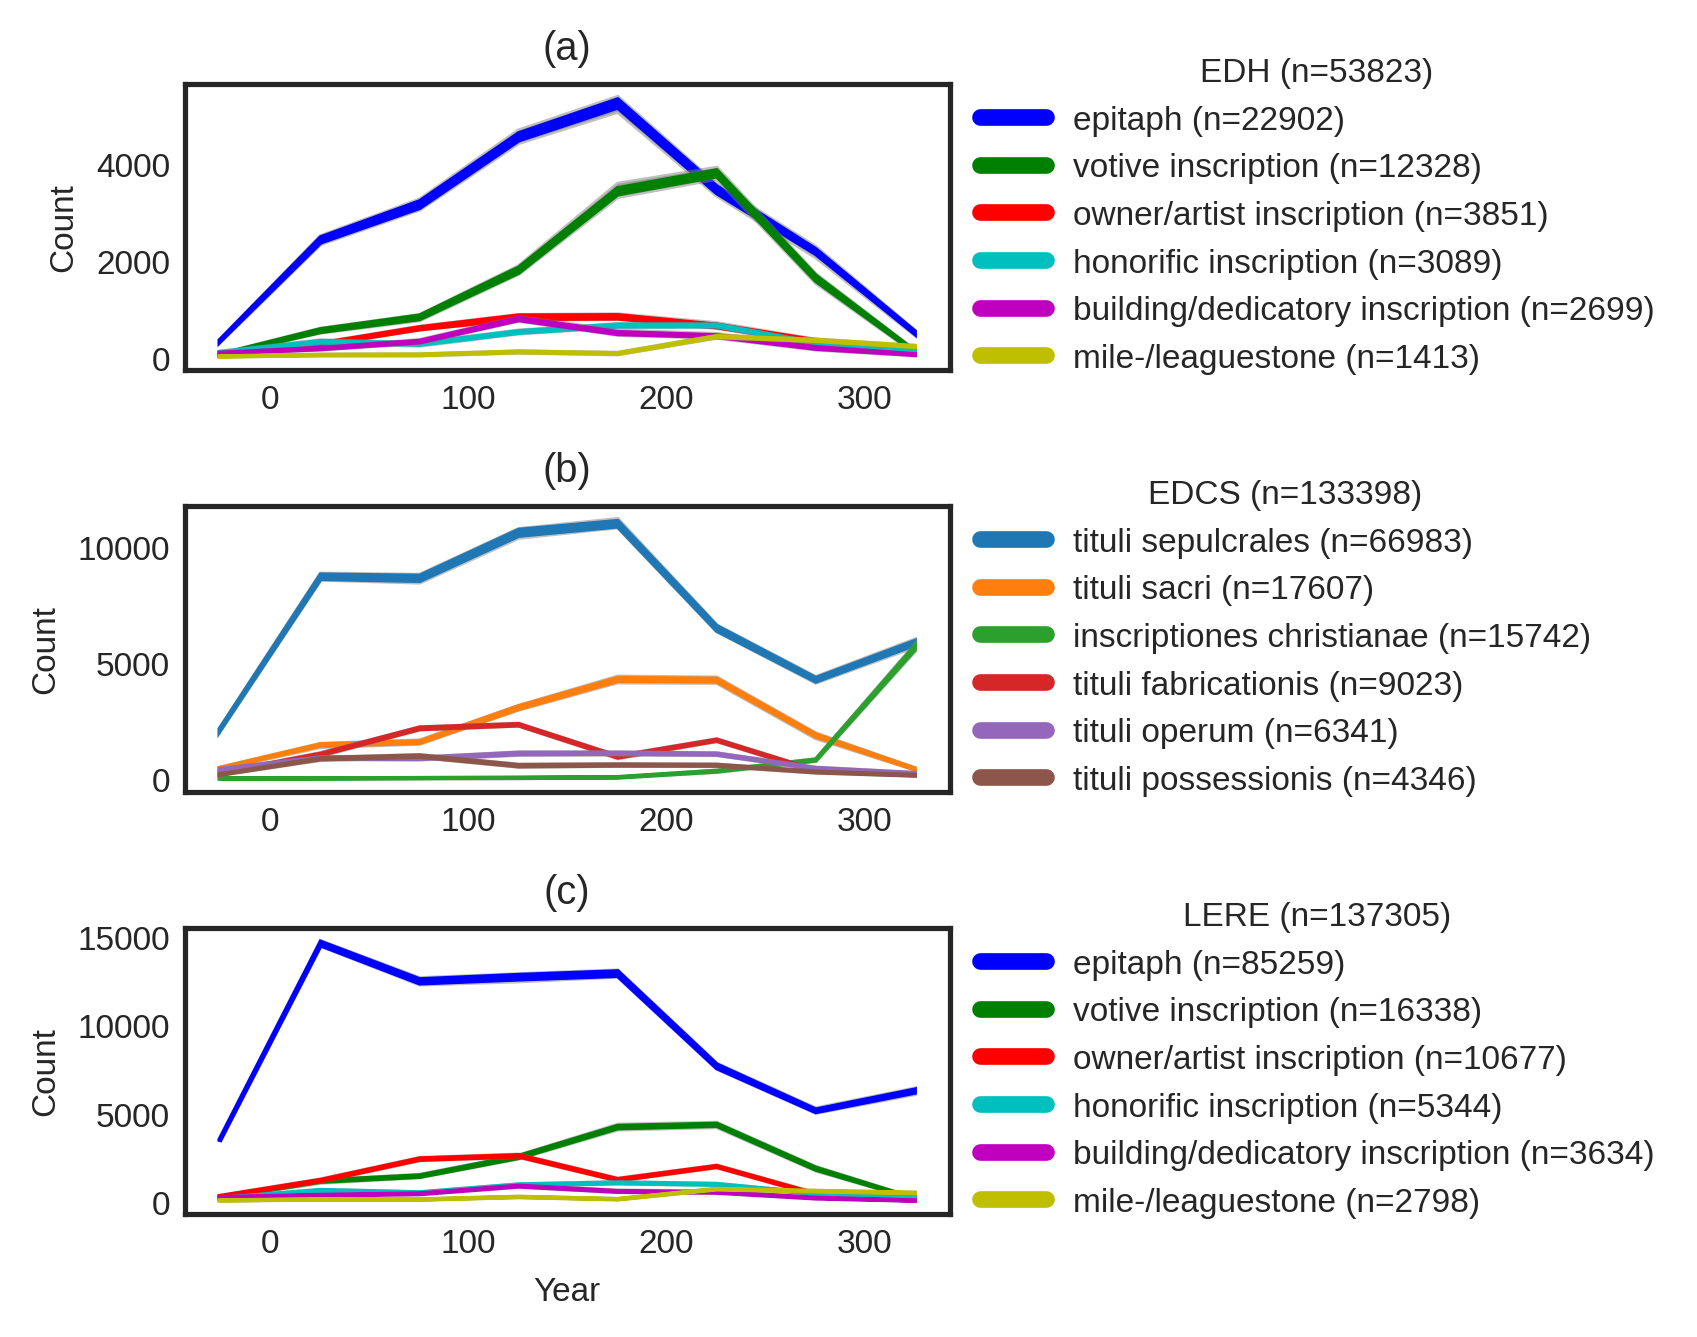

In [225]:
%%time
# Figure 2
# Plot combining EDH and EDCSx
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(5.7, 4.5), dpi=300, tight_layout=True)

# EDH

for ins_type_sims, color in zip(simulations_by_type_EDH[:6], base_colors_10[:6]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_ylabel("Count")
#ax1.set_title(f"Eight most common inscription types over time (EDH, n={len(EDH_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in base_colors_10[:6]]

legend_labels_EDH = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDH][:6]

ax1.legend(markers, legend_labels_EDH, numpoints=1,  
           title="EDH (n={0})".format(str(len(EDHCSg[EDHCSg["EDH-ID"].notnull()]))), fontsize=8, bbox_to_anchor=(1, 1.2), loc='upper left')

ax1.set_title("(a)")

# EDCS

for ins_type_sims, color in zip(simulations_by_type_EDCS[:6], tab_colors_list[:6]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)


ax2.set_ylabel("Count")
#ax1.set_title(f"Eight most common inscription types over time (EDH, n={len(EDH_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:6]]

legend_labels_EDCS = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDCS][:6]

ax2.legend(markers, legend_labels_EDCS, numpoints=1,  
           title="EDCS (n={0})".format(str(len(EDHCSg[EDHCSg["EDCS-ID"].notnull()]))), fontsize=8, bbox_to_anchor=(1, 1.2), loc='upper left')

ax2.set_title("(b)")



# EDHCS

for ins_type_sims, color in zip(simulations_by_type_EDHCS[:6], base_colors_10[:6]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax3, color=color)

ax3.set_xlabel("Year")
ax3.set_ylabel("Count")
#ax2.set_title(f"Eight most common inscription types over time (EDCSx, n={len(EDCSx_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in base_colors_10[:6]]

legend_labels_EDHCS = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDHCS][:6]

ax3.legend(markers, legend_labels_EDHCS, numpoints=1, title="LERE (n={0})".format(str(len(EDHCSg))), fontsize=8, bbox_to_anchor=(1, 1.2), loc='upper left')

ax3.set_title("(c)")



# plt.savefig('Fig2_Typologies_comparison_time.png')

In [226]:
s.write_file(figpath + "diachronic_overview.png", fig)

A file with the same name ("diachronic_overview.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/EDHCS/CHR2021/diachronic_overview.png"
